# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of an image classifier, from loading and inspecting the dataset to implementing and training a Convolutional Neural Network architecture. The sections guide you but you do not have to follow that specific order.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you using Colab notebook, save it as .ipynb and upload it. If you have your own machine with Jupyter installed, you can work there as well. Upload only the .ipynb file.


## Rules and Comments
- From the list of datasets and architectures listed in Canvas, each student was assigned **1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description.
- This is a DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course).
- **Deadline is October 17th 11:59 PM** (For late submission it is October 23rd 11:59PM)
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

**Name:** Enes Çalışkan

**Neptun ID:** 

**Network:** Resnet18

**Objects:** GTSRB - German Traffic Sign Recognition Benchmark

## Task description

Your task is to compare the performance of a given pre-trained model and a modified version of it, using a given dataset. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem.

Steps
1. If your dataset has more than 5 classes, then select 5 classes of your choice (explain why). If your dataset has 5 or less classes, ignore this step.
2. The dataset should be split into train, validation and test sets. Some datasets already have these splits, otherwise, you can split the training set into validation and test sets.
3. Use the test set to do inference with the pre-trained model. Calculate the accuracy of the pre-trained model.
4. Modify the pre-trained model and train it with the train/validation sets. Modifying means removing/replacing/adding layers. We recommend changing the: head (you need to do this because the pre-trained models were created to predict 1000 classes from Imagenet, however, in your case, the number of classes is different, so you must change the head); backbone (remove/replace layers in the backbone. Be aware that once you do that, you need to be able to adjust the networks output dimensions by changing the properties like filter size, padding, etc)
5. Use the test set to do inference with the newly modified/trained model. Calculate the accuracy.
6. Compare the results from the pre-trained model and the modified version.
7. Explain the differences.
Please submit only the notebook to Canvas. (Do not upload the dataset nor the models)

There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualizations (matplotlib, seaborn, ...) of the accuracy, loss, and confusion matrix. Use Early stopping and save the best model while training your network.


# In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.


There are some example questions at the end of the notebook.

## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import os
import random
from shutil import copyfile
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import numpy as np

if torch.cuda.is_available():  # Checking if using Cuda or CPU
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cuda.


## 1. Dataset
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Mounting Google Drive


In [2]:
# Based on my research, i have found out that loading the dataset from Google Drive yields the fastest runtime,
# therefore i chose to load my dataset from Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Extracting the .zip File

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


#### Loading the data from .csv files

My dataset has already been splitted into 3 folders; Test, Train and Meta(Validation). However, only "Train" folder has subfolders to classify as "labels". Therefore, i am using .csv files that is provided withing the dataset as a guide to load my images and labels. Also, my dataset has 42 classes, so i am choosing 5 classes among them as instructed and loading them.

In [4]:
# Loading the CSV files
train_csv = pd.read_csv('Train.csv')
meta_csv = pd.read_csv('Meta.csv')
test_csv = pd.read_csv('Test.csv')

# Defining the 5 classes i want to train on. In here we can see that i chose the classes from 0 to 4 for training.
target_classes = [0, 1, 2, 3, 4]

# Filtering data
filtered_train_csv = train_csv[train_csv['ClassId'].isin(target_classes)]
filtered_meta_csv = meta_csv[meta_csv['ClassId'].isin(target_classes)]
filtered_test_csv = test_csv[test_csv['ClassId'].isin(target_classes)]

# I am defining the transformations that i want to do in my sets.
# The reason that i am doing basic transformations is that,
# since the size of my dataset is fairly large, it takes a very long time to
# train and evaluate the model.

transformTrain = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

transformMeta = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

transformTest = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

#### Defining Custom Datasets

The reason that i am defining a custom dataset is that my dataset's .csv files are not well aligned and well structered to be loaded just yet. For example, in meta.csv, path to images is the last element whilst in train.csv and test.cvs, path is the first element. Also, these csv files contains all the information in one column, hence i feel the need to divide them in order to load my data.

In [5]:
# Defining the custom Dataset for Meta

class CustomDatasetMeta(Dataset):
    def __init__(self, csv_data, root_dir, transform=None):
        self.data = csv_data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path_and_label = self.data.iloc[idx, 0]  # Assuming the first column contains image paths
        label = self.data.iloc[idx, 1]  # Assuming the second column contains the labels
        img_path = os.path.join('', img_path_and_label)  # Combining the path with the folder containing my images

        image = Image.open(img_path).convert('RGB')
        label = int(label)  # Converting the label to an integer

        if self.transform:
            image = self.transform(image)

        return image, label

    transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Define a custom dataset for Train and Test sets

class CustomDatasetTestAndTrain(Dataset):
    def __init__(self, csv_data, root_dir, transform=None):
        self.data = csv_data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path_and_label = self.data.iloc[idx, -1]  # Assuming the last column contains image paths
        label = self.data.iloc[idx, -2]  # Assuming the second last column contains the labels
        img_path = os.path.join('', img_path_and_label)  # Combining the path with the folder containing my images

        image = Image.open(img_path).convert('RGB')
        label = int(label)  # Converting the label to an integer

        if self.transform:
            image = self.transform(image)

        return image, label

#### Loading the train, test and meta(eval) datasets.

In [6]:
train_dataset = CustomDatasetTestAndTrain(filtered_train_csv, 'path_to_train_images', transform=transformTrain)
meta_dataset = CustomDatasetMeta(filtered_meta_csv, 'path_to_meta_images', transform=transformMeta)
test_dataset = CustomDatasetTestAndTrain(filtered_test_csv, 'path_to_test_images', transform=transformTest)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
meta_loader = DataLoader(meta_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

#### Number of images for each class in Train Dataset

In [40]:
from collections import Counter
trainLabels = []

for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    label_str = str(label)
    trainLabels.append(label_str)

Counter(trainLabels)


Counter({'0': 210, '1': 2220, '2': 2250, '3': 1410, '4': 1980})

#### Number of images for each class in Test Dataset

In [41]:
testLabels = []

for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    testLabel_str = str(label)
    testLabels.append(testLabel_str)

Counter(testLabels)


Counter({'1': 720, '4': 660, '3': 450, '2': 750, '0': 60})

#### Displaying the example images

In this section, i want to see the pictures from my eval and train dataset after the transformations that i applied to check everything is in order.

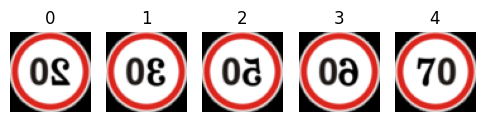

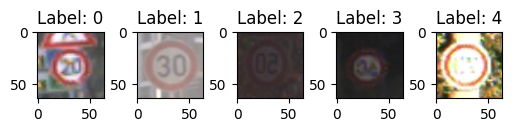

In [7]:
meta_dataset = sorted(meta_dataset, key=lambda x: x[1]) # Sorting the images so they look in order

# DISPLAYING EVAL IMAGES
fig, axs = plt.subplots(1, 5, figsize=(6, 6))
fig.subplots_adjust(hspace=1)
axs = axs.ravel()

for i, (image, label) in enumerate(meta_dataset):
    image = image.permute(1, 2, 0).numpy() # Converting the PyTorch tensor image to a NumPy array

    axs[i].imshow(image)
    axs[i].set_title(f"{label}")
    axs[i].axis('off')

plt.show()

# DISPLAY TRAIN IMAGES

# Defining a transform to convert the image for display
transform = transforms.ToPILImage()

# Creating a dictionary to store one example image for each unique label
example_images = {}

# Iterating through the train dataset to collect one example for each unique label
for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    label_str = str(label)  # Converting label to a string for dictionary keys

    if label_str not in example_images:
        example_images[label_str] = image

transform = transforms.ToPILImage()

# Creating a figure to display images and labels in one row
fig, ax = plt.subplots(1, len(example_images), figsize=(6, 6))

# Iterating through the unique labels and their example images
for idx, (label, image) in enumerate(example_images.items()):
    image_for_display = transform(image)
    ax[idx].imshow(image_for_display)
    ax[idx].set_title(f"Label: {label}")

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.5)

# Show the figure with images and labels in one row
plt.show()

## 2. Convolutional Neural Network Architecture
Load the pre-trained CNN architecture you were given. Reduce the size of the given model by removing some layers and parameters with less influence. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the given pre-trained model

Again, i am doing some mapping since i am selecting 5 datasets out of 42 and i have faced array errors along the way. I know that this mapping does not make sense but i tried different classes rather than 0,1,2,3,4 in previous iterations so i still wanted to keep it in case i want to change my selected 5 classes to other ones.

In [8]:
label_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

mapped_train_dataset = []
for i in range(len(train_dataset)):
    image, original_label = train_dataset[i]
    mapped_label = label_mapping[original_label]
    mapped_train_dataset.append((image, mapped_label))

# Defining a DataLoader for training with the new dataset
train_loader = DataLoader(mapped_train_dataset, batch_size=32, shuffle=True)

In [9]:
# Defining my model architecture

pretrained_model = models.resnet18(pretrained=True)
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 5)  # 5 classes for the new label order

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 269MB/s]


#### Summary of Model(Resnet18)


In [10]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 3. Training

#### Define your loss function

In [11]:
criterion = nn.CrossEntropyLoss()

#### Define your optimizer

In [12]:
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

#### Train your network

The reason that i am using 3 epochs is that since the size of the dataset is fairly large and i want to test the changes that i have done on my dataset frequently, i chose fewer epoch to avoid longer waiting times.

In [13]:
# Training the model

num_epochs = 3
pretrained_model.train()

training_epochs = []
epoch_accuracies = []

for epoch in range(num_epochs):
    pretrained_model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    epoch_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%")
    training_epochs.append(epoch_loss)

Epoch 1/3, Loss: 0.4690, Training Accuracy: 82.45%
Epoch 2/3, Loss: 0.0634, Training Accuracy: 98.15%
Epoch 3/3, Loss: 0.0314, Training Accuracy: 99.10%


#### Save your trained CNN

In [14]:
torch.save(pretrained_model.state_dict(), 'model.pth')

## 4. Evaluation and Testing
Load your trained CNN and evaluate it on the test set.
Show the confusion matrix on the test set.
Show some predictions on the test set (3 is enough) by plotting the image and printing the prediction and ground truth.
Show some missed predictions (3 is enough) and try to explain why it was difficult for the model to recognize these images.

#### Evaluate your model

In [15]:
pretrained_model.eval()

# Evaluation dataset
eval_loader = DataLoader(test_dataset, batch_size=32)

# Initializing variables to keep track of correct and total predictions
correct = 0
total = 0
validation_accuracy = []
true_labels = []
predicted_labels = []


# Iterating over the evaluation dataset
for inputs, labels in eval_loader:
    # Forward pass (compute predictions)
    outputs = pretrained_model(inputs)

    # Compute predicted labels
    _, predicted = torch.max(outputs, 1)

    # Update counts of correct and total predictions
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    loss /= len(eval_loader)
    # Calculate accuracy
    accuracy = 100 * correct / total

    print(f"Validation Accuracy: {accuracy:.2f}%")
    validation_accuracy.append(accuracy)

    true_labels.append(correct)
    predicted_labels.append(total)




Validation Accuracy: 96.88%
Validation Accuracy: 95.31%
Validation Accuracy: 94.79%
Validation Accuracy: 93.75%
Validation Accuracy: 93.75%
Validation Accuracy: 91.15%
Validation Accuracy: 91.52%
Validation Accuracy: 92.58%
Validation Accuracy: 92.71%
Validation Accuracy: 92.81%
Validation Accuracy: 93.18%
Validation Accuracy: 92.19%
Validation Accuracy: 91.83%
Validation Accuracy: 91.96%
Validation Accuracy: 91.67%
Validation Accuracy: 90.62%
Validation Accuracy: 90.99%
Validation Accuracy: 91.15%
Validation Accuracy: 91.28%
Validation Accuracy: 91.41%
Validation Accuracy: 91.82%
Validation Accuracy: 92.05%
Validation Accuracy: 91.98%
Validation Accuracy: 91.93%
Validation Accuracy: 91.62%
Validation Accuracy: 91.83%
Validation Accuracy: 91.67%
Validation Accuracy: 91.63%
Validation Accuracy: 91.70%
Validation Accuracy: 91.88%
Validation Accuracy: 91.94%
Validation Accuracy: 91.80%
Validation Accuracy: 91.67%
Validation Accuracy: 91.82%
Validation Accuracy: 91.88%
Validation Accuracy:

#### Show the test accuracy next to the training and validation

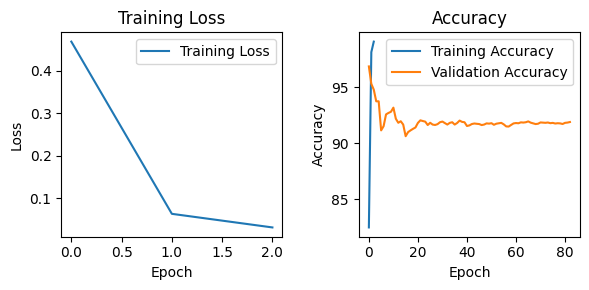

In [16]:
# Create a figure
plt.figure(figsize=(6, 3))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(training_epochs, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

#### Confusion matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 78.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


<Figure size 800x600 with 0 Axes>

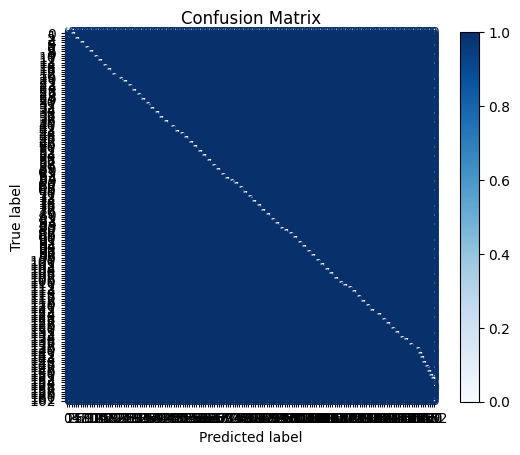

In [17]:
!pip install --upgrade pip
!pip uninstall --yes --quiet osqp
!pip install -U scikit-survival

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(cmap="Blues", values_format='')

plt.title("Confusion Matrix")
plt.show()

#### Changing the model and using non-pretrained model to compare the results

In [25]:
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(512, 100),
    nn.ReLU(),
    nn.Linear(100, 40),
    nn.ReLU(),
    nn.Linear(40, 20))
out = model(torch.randn(2, 3, 224, 224))
print(out.shape)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training the model

num_epochs = 5
model.train()

model_training_epochs = []
model_epoch_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    model_epoch_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%")
    model_training_epochs.append(epoch_loss)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([2, 20])
Epoch 1/5, Loss: 1.7390, Training Accuracy: 32.04%
Epoch 2/5, Loss: 1.1047, Training Accuracy: 53.97%
Epoch 3/5, Loss: 0.6116, Training Accuracy: 77.82%
Epoch 4/5, Loss: 0.2582, Training Accuracy: 91.10%
Epoch 5/5, Loss: 0.1191, Training Accuracy: 96.03%


In [26]:
model.eval()

# Evaluation dataset
eval_loader = DataLoader(test_dataset, batch_size=32)

# Initializing variables to keep track of correct and total predictions
correct = 0
total = 0
model_validation_accuracy = []
model_true_labels = []
mode_predicted_labels = []


# Iterating over the evaluation dataset
for inputs, labels in eval_loader:
    # Forward pass (compute predictions)
    outputs = model(inputs)

    # Compute predicted labels
    _, predicted = torch.max(outputs, 1)

    # Update counts of correct and total predictions
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    loss /= len(eval_loader)
    # Calculate accuracy
    accuracy = 100 * correct / total

    print(f"Validation Accuracy: {accuracy:.2f}%")
    model_validation_accuracy.append(accuracy)

    model_true_labels.append(correct)
    mode_predicted_labels.append(total)

Validation Accuracy: 81.25%
Validation Accuracy: 78.12%
Validation Accuracy: 81.25%
Validation Accuracy: 81.25%
Validation Accuracy: 80.62%
Validation Accuracy: 81.25%
Validation Accuracy: 82.59%
Validation Accuracy: 83.98%
Validation Accuracy: 85.42%
Validation Accuracy: 85.94%
Validation Accuracy: 85.23%
Validation Accuracy: 84.38%
Validation Accuracy: 84.62%
Validation Accuracy: 85.04%
Validation Accuracy: 84.58%
Validation Accuracy: 84.96%
Validation Accuracy: 85.11%
Validation Accuracy: 85.07%
Validation Accuracy: 85.53%
Validation Accuracy: 85.78%
Validation Accuracy: 86.01%
Validation Accuracy: 86.22%
Validation Accuracy: 86.01%
Validation Accuracy: 86.33%
Validation Accuracy: 85.62%
Validation Accuracy: 85.82%
Validation Accuracy: 85.88%
Validation Accuracy: 85.38%
Validation Accuracy: 85.45%
Validation Accuracy: 85.21%
Validation Accuracy: 84.98%
Validation Accuracy: 84.67%
Validation Accuracy: 85.04%
Validation Accuracy: 85.11%
Validation Accuracy: 85.09%
Validation Accuracy:

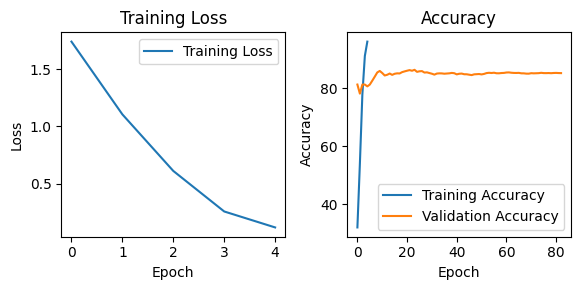

In [27]:
# Create a figure
plt.figure(figsize=(6, 3))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(model_training_epochs, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model_epoch_accuracies, label='Training Accuracy')
plt.plot(model_validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

## 5. Some example questions that help you prepare for the defense

* Data
    - Describe your dataset.
    - List augmentation techniques.
    - Normalization standardization why do we use them?

* Model
    - Describe the model and its parameters (Convolutional Layer, Pooling
    - Layer, flatten, concatenation, activation, linear, argmax().
    - How can we change the output dimension? What happens if we change the head or the backbone? (filter number or replace them,...).

* optimizer
    - Describe the optimizer. What parameters does it have? (some connection to the date, model, and loss function)

* Loss function and regularisation
    - Describe the loss functions and some regularization methods.

* Results
    - Describe the results based on overfitting, underfitting, bias, and variance.
    - Does the trained model complete the given task? What is the baseline for classification?
    - Then the data balance, if it were unbalanced how would they deal with it?
    - What other aspects can cause biased output? What simple methods do we have to unbias the model?
    - Try to explain why it was difficult for the model to recognize the missed predictions.
    - How can we improve the model?

#### Answer the questions (optional, but recommended for the  preparation)

In [ ]:
# ADD YOUR ANSWERS HERE